## Analyses functions

In [1]:
import networkx as nx


def bidirectional_onion_layers(graph):

    # Dictionaries to register the k-core/onion decompositions.
    incoreness_map = {}
    inlayer_map = {}
    outcoreness_map = {}
    outlayer_map = {}

    # Creates a copy of the graph (to be able to remove vertices and edges)
    the_graph = nx.MultiDiGraph(graph)

    # Performs the inward onion decomposition (low in degree first).
    current_core = 0
    current_layer = 1
    while the_graph.number_of_nodes() > 0:
        # Sets properly the current core.
        indegree_sequence = [the_graph.in_degree(node) for node in the_graph.nodes()]
        min_degree = min(indegree_sequence)
        if min_degree >= (current_core + 1):
            current_core = min_degree
        # Identifies vertices in the current layer.
        this_layer_ = []
        for v in the_graph.nodes():
            if the_graph.in_degree(v) <= current_core:
                this_layer_.append(v)
        # Identifies the core/layer of the vertices in the current layer.
        for v in this_layer_:
            incoreness_map[v] = current_core
            inlayer_map[v] = current_layer
            the_graph.remove_node(v)
        # Updates the layer count.
        current_layer = current_layer + 1

    # Creates a 2nd copy of the graph (to be able to remove vertices and edges)
    the_graph = nx.MultiDiGraph(graph)

    # Performs the outward onion decomposition (low out degree first).
    current_core = 0
    current_layer = 1
    while the_graph.number_of_nodes() > 0:
        # Sets properly the current core.
        outdegree_sequence = [the_graph.out_degree(node) for node in the_graph.nodes()]
        min_degree = min(outdegree_sequence)
        if min_degree >= (current_core + 1):
            current_core = min_degree
        # Identifies vertices in the current layer.
        this_layer_ = []
        for v in the_graph.nodes():
            if the_graph.out_degree(v) <= current_core:
                this_layer_.append(v)
        # Identifies the core/layer of the vertices in the current layer.
        for v in this_layer_:
            outcoreness_map[v] = current_core
            outlayer_map[v] = current_layer
            the_graph.remove_node(v)
        # Updates the layer count.
        current_layer = current_layer + 1

    # Returns the dictionaries containing the k-shell and onion layer of each vertices.
    return (inlayer_map, incoreness_map, outlayer_map, outcoreness_map)

In [2]:
import networkx as nx


def directed_onion_layers(graph):

    # Dictionaries to register the k-core/onion decompositions.
    bicoreness_map = {}
    bilayer_map = {}

    # Creates a copy of the graph (to be able to remove vertices and edges)
    the_graph = nx.MultiDiGraph(graph)

    # Performs the inward onion decomposition (low in degree first).
    current_core = 0
    current_layer = 1
    while the_graph.number_of_nodes() > 0:
        # Sets properly the current core.
        degree_sequence = [
            min(the_graph.in_degree(node), the_graph.in_degree(node))
            for node in the_graph.nodes()
        ]
        min_degree = min(degree_sequence)
        if min_degree >= (current_core + 1):
            current_core = min_degree
        # Identifies vertices in the current layer.
        this_layer_ = []
        for v in the_graph.nodes():
            if (
                the_graph.in_degree(v) <= current_core
                or the_graph.out_degree(v) <= current_core
            ):
                this_layer_.append(v)
        # Identifies the core/layer of the vertices in the current layer.
        for v in this_layer_:
            bicoreness_map[v] = current_core
            bilayer_map[v] = current_layer
            the_graph.remove_node(v)
        # Updates the layer count.
        current_layer = current_layer + 1

    # Returns the dictionaries containing the k-shell and onion layer of each vertices.
    return (bilayer_map, bicoreness_map)

In [3]:
import networkx as nx
import numpy
import scipy
import scipy.linalg


def get_katz_centrality(graph):

    # Calculate max eigenvalue of adjacency matrix for convergence
    # phi = max(nx.adjacency_spectrum(graph, weight= 'weight'))
    # Iterative calculation of Katz centrality (beta is the importance of papers)
    centrality = nx.katz_centrality(
        G, alpha=0.001, beta=1.0, weight="weight", max_iter=100000
    )

    # Returns the dictionary containing the centrality of each node
    return centrality

## PyPI analyses

In [4]:
import networkx as nx
import pandas as pd

G0 = nx.read_gexf("../data/dois-graph/full-graph.gexf")

cc = sorted(nx.weakly_connected_components(G0), key=len, reverse=True)
G = G0.subgraph(cc[0])

In [5]:
(inlayer_map, incoreness_map, outlayer_map, outcoreness_map) = (
    bidirectional_onion_layers(G)
)
(layer_map, coreness_map) = directed_onion_layers(G)
centrality_map = get_katz_centrality(G)

nx.set_node_attributes(G, centrality_map, "Katz")
nx.set_node_attributes(G, layer_map, "layer")
nx.set_node_attributes(G, coreness_map, "core")

nx.write_gexf(G, "../data/pruned-network.gexf")
pd.DataFrame.from_dict(
    dict(G.nodes(data=True)),
    orient="index",
).reset_index(names=["Id"])[
    [
        "Id",
        "label",
        "Katz",
        "layer",
        "core",
        "ecosystem",
        "czi_id",
        "keywords",
        "mentions_count",
    ]
].rename(
    columns={"label": "Label"},
).to_csv(
    "../data/pruned-network.csv",
    index=False,
)

In [6]:
max_out = outcoreness_map[max(outcoreness_map, key=outcoreness_map.get)]
max_in = incoreness_map[max(incoreness_map, key=incoreness_map.get)]
max_bi = coreness_map[max(coreness_map, key=coreness_map.get)]

print(max_out, max_in, max_bi)

0 0 0


In [7]:
print(max(3, 2))

3


0 282756
[[1.]]


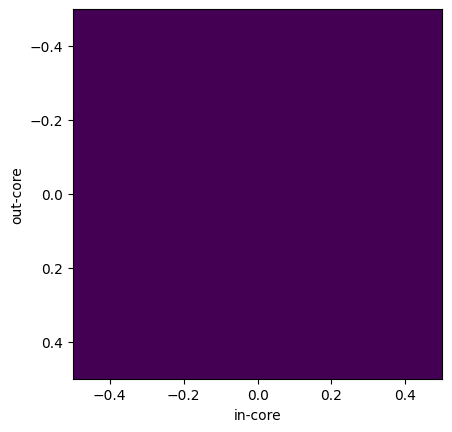

In [8]:
import numpy as np

for K in np.arange(1 + max(max_out, max_in)):
    res = 0
    for key in outcoreness_map:
        if outcoreness_map[key] >= K and incoreness_map[key] >= K:
            res += 1
    print(K, res)

matrix = np.zeros((1 + max_out, 1 + max_in))
for key in outcoreness_map:
    matrix[outcoreness_map[key], incoreness_map[key]] += 1

import matplotlib.pyplot as plt

print(matrix / G.number_of_nodes())
plt.imshow(np.log10(matrix))
plt.xlabel("in-core")
plt.ylabel("out-core")
plt.show()

In [9]:
# for key in outcoreness_map:
#    if outcoreness_map[key]>=3 and incoreness_map[key]>=3:
#        print(key,list(G.neighbors(key)))

## Plot results

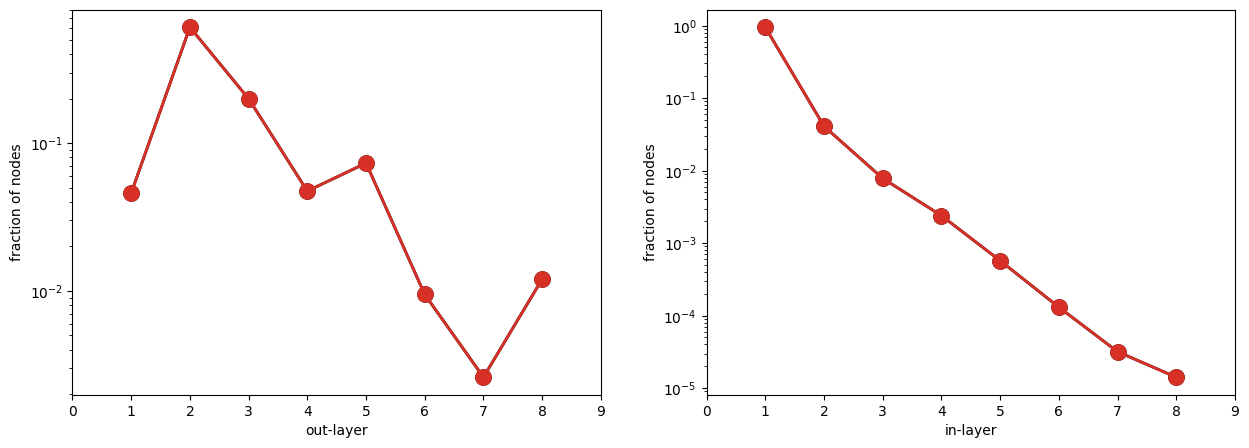

In [10]:
import numpy as np
import math
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Computes the relevant quantities from the data.
n_core_out = np.array([*outcoreness_map.values()], dtype=object)
n_pass_out = np.array([*outlayer_map.values()], dtype=object)
n_core_in = np.array([*incoreness_map.values()], dtype=object)
n_pass_in = np.array([*inlayer_map.values()], dtype=object)

# Computes the bounds.
c_min_out = int(min(n_core_out))
c_max_out = int(max(n_core_out))
p_min_out = int(min(n_pass_out))
p_max_out = int(max(n_pass_out))
c_min_in = int(min(n_core_in))
c_max_in = int(max(n_core_in))
p_min_in = int(min(n_pass_in))
p_max_in = int(max(n_pass_in))

# Computes the histograms.
bins_out = np.arange(p_min_out, p_max_out + 1 + 1) - 0.5
p_his_out = np.histogram(n_pass_out, bins_out, density=False)[0]
nb_nodes = sum(p_his_out)
p_his_out = p_his_out / float(nb_nodes)
bins_in = np.arange(p_min_in, p_max_in + 1 + 1) - 0.5
p_his_in = np.histogram(n_pass_in, bins_in, density=False)[0]
p_his_in = p_his_in / float(nb_nodes)

# Computes the pass2core relation
pass2core_out = np.zeros(int(p_max_out) + 3)
for n in range(len(n_core_out)):
    c = n_core_out[n]
    p = n_pass_out[n]
    pass2core_out[p] = c
pass2core_in = np.zeros(int(p_max_in) + 1 + 1)
for n in range(len(n_core_in)):
    c = n_core_in[n]
    p = n_pass_in[n]
    pass2core_in[p] = c

# Sets the color of the markers in the scatter plot
# colormap = colmap.cmap_bwready(c_max-c_min+1,1)
colormap = np.tile(
    np.array(
        [
            [215, 252, 254, 171, 145, 69],
            [48, 141, 224, 217, 191, 117],
            [39, 89, 144, 233, 219, 180],
        ]
    )
    / float(255),
    (1, math.ceil(float(max(c_max_out, c_max_in) + 1) / 6)),
)

colors_out = np.zeros((len(p_his_out), 3))
colors_in = np.zeros((len(p_his_in), 3))
for p in range(len(p_his_out)):
    colors_out[p, :] = colormap[:, int(pass2core_out[p + 1])]
for p in range(len(p_his_in)):
    colors_in[p, :] = colormap[:, int(pass2core_in[p + 1])]

# Adds a shaded area.
# plt.axvspan(1100, 1150, facecolor=[0.75,0.75,0.75], edgecolor='None', alpha=0.5)
# plt.axvspan(100, 230, facecolor=[0.75,0.75,0.75], edgecolor='None', alpha=0.5)


# Plots the histogram.
x_core = []
y_core = []
current_c = c_min_out
x_his = np.arange(p_min_out, p_max_out + 5)
for i in range(0, len(p_his_out)):
    if pass2core_out[i + 1] == current_c:
        x_core.append(x_his[i])
        y_core.append(p_his_out[i])
    else:
        ax1.plot(x_core, y_core, c="Black", marker="o", ms=12, ls="-", lw=2, mec="None")
        ax1.plot(
            x_core,
            y_core,
            c=colors_out[i - 1, :],
            marker="o",
            ms=12,
            ls="-",
            lw=2,
            mec="None",
        )
        x_core = []
        y_core = []
        x_core.append(x_his[i])
        y_core.append(p_his_out[i])
        current_c = pass2core_out[i + 1]
    if i == len(p_his_out) - 1:
        ax1.plot(x_core, y_core, c="Black", marker="o", ms=12, ls="-", lw=2, mec="None")
        ax1.plot(
            x_core,
            y_core,
            c=colors_out[i, :],
            marker="o",
            ms=12,
            ls="-",
            lw=2,
            mec="None",
        )
# ax.scatter(x_his,   p_his, c=colors, marker='o', s=36)
# ax.plot(x_his,   p_his, c='#af773e', ls='None',     marker='s', ms=10)
x_core = []
y_core = []
current_c = c_min_in
x_his = np.arange(p_min_in, p_max_in + 5)
for i in range(0, len(p_his_in)):
    if pass2core_in[i + 1] == current_c:
        x_core.append(x_his[i])
        y_core.append(p_his_in[i])
    else:
        ax2.plot(x_core, y_core, c="Black", marker="o", ms=12, ls="-", lw=2, mec="None")
        ax2.plot(
            x_core,
            y_core,
            c=colors_in[i - 1, :],
            marker="o",
            ms=12,
            ls="-",
            lw=2,
            mec="None",
        )
        x_core = []
        y_core = []
        x_core.append(x_his[i])
        y_core.append(p_his_in[i])
        current_c = pass2core_in[i + 1]
    if i == len(p_his_in) - 1:
        ax2.plot(x_core, y_core, c="Black", marker="o", ms=12, ls="-", lw=2, mec="None")
        ax2.plot(
            x_core,
            y_core,
            c=colors_in[i, :],
            marker="o",
            ms=12,
            ls="-",
            lw=2,
            mec="None",
        )

# Sets log scale
ax1.set_yscale("log")
ax2.set_yscale("log")


# Sets limits
ax1.set_xlim(0, p_max_out + 1)
ax2.set_xlim(0, p_max_in + 1)

# Axes label.
ax1.set_xlabel(r"out-layer")
ax1.set_ylabel(r"fraction of nodes")
ax2.set_xlabel(r"in-layer")
ax2.set_ylabel(r"fraction of nodes")

plt.show()

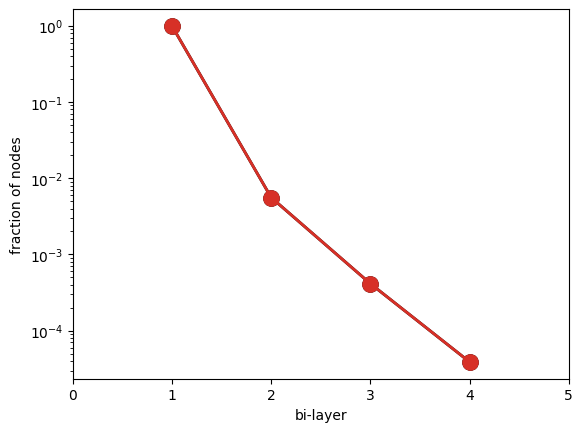

In [11]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Computes the relevant quantities from the data.
n_core_out = np.array([*coreness_map.values()], dtype=object)
n_pass_out = np.array([*layer_map.values()], dtype=object)

# Computes the bounds.
c_min_out = int(min(n_core_out))
c_max_out = int(max(n_core_out))
p_min_out = int(min(n_pass_out))
p_max_out = int(max(n_pass_out))
# Computes the histograms.
bins_out = np.arange(p_min_out, p_max_out + 1 + 1) - 0.5
p_his_out = np.histogram(n_pass_out, bins_out, density=False)[0]
nb_nodes = sum(p_his_out)
p_his_out = p_his_out / float(nb_nodes)

# Computes the pass2core relation
pass2core_out = np.zeros(int(p_max_out) + 3)
for n in range(len(n_core_out)):
    c = n_core_out[n]
    p = n_pass_out[n]
    pass2core_out[p] = c

# Sets the color of the markers in the scatter plot
# colormap = colmap.cmap_bwready(c_max-c_min+1,1)
colormap = np.tile(
    np.array(
        [
            [215, 252, 254, 171, 145, 69],
            [48, 141, 224, 217, 191, 117],
            [39, 89, 144, 233, 219, 180],
        ]
    )
    / float(255),
    (1, math.ceil(float(c_max_out + 1) / 6)),
)

colors_out = np.zeros((len(p_his_out), 3))
for p in range(len(p_his_out)):
    colors_out[p, :] = colormap[:, int(pass2core_out[p + 1])]

# Adds a shaded area.
# plt.axvspan(1100, 1150, facecolor=[0.75,0.75,0.75], edgecolor='None', alpha=0.5)
# plt.axvspan(100, 230, facecolor=[0.75,0.75,0.75], edgecolor='None', alpha=0.5)


# Plots the histogram.
x_core = []
y_core = []
current_c = c_min_out
x_his = np.arange(p_min_out, p_max_out + 5)
for i in range(0, len(p_his_out)):
    if pass2core_out[i + 1] == current_c:
        x_core.append(x_his[i])
        y_core.append(p_his_out[i])
    else:
        plt.plot(x_core, y_core, c="Black", marker="o", ms=12, ls="-", lw=2, mec="None")
        plt.plot(
            x_core,
            y_core,
            c=colors_out[i - 1, :],
            marker="o",
            ms=12,
            ls="-",
            lw=2,
            mec="None",
        )
        x_core = []
        y_core = []
        x_core.append(x_his[i])
        y_core.append(p_his_out[i])
        current_c = pass2core_out[i + 1]
    if i == len(p_his_out) - 1:
        plt.plot(x_core, y_core, c="Black", marker="o", ms=12, ls="-", lw=2, mec="None")
        plt.plot(
            x_core,
            y_core,
            c=colors_out[i, :],
            marker="o",
            ms=12,
            ls="-",
            lw=2,
            mec="None",
        )
# ax.scatter(x_his,   p_his, c=colors, marker='o', s=36)
# ax.plot(x_his,   p_his, c='#af773e', ls='None',     marker='s', ms=10)

# Sets log scale
plt.yscale("log")


# Sets limits
plt.xlim(0, p_max_out + 1)

# Axes label.
plt.xlabel(r"bi-layer")
plt.ylabel(r"fraction of nodes")

plt.show()